In [32]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Import packages
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import sklearn.metrics as metrics
import pysentiment2 as ps
import scikitplot as skplt
from sklearn.metrics import mean_squared_error as mse
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, PlaintextCorpusReader
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn import preprocessing


In [33]:
data = pd.read_csv(r'C:\Users\yahsk\Desktop\github\ML hw6\business_insider_text_data2.csv')
# Merge all headlines from the same dates.
data = data.groupby('Date')['Headline'].apply(lambda x: "%s" % ', '.join(x))
data = pd.DataFrame(data)
vix_data = pd.read_csv(r'C:\Users\yahsk\Desktop\github\ML hw6\vix_data.csv')
vix_data.index=vix_data.Date
vix_data = vix_data[['label']]

### Preprocess the headlines using create_df function from the code snippets
def create_df(dataset):
    stop_words = set(stopwords.words('english'))
    lm = ps.LM()
    # dataset = dataset.drop(columns=['Date', 'Label'])
    dataset.replace("[^a-zA-Z]", " ", regex=True, inplace=True)
    for col in dataset.columns:
        dataset[col] = dataset[col].str.lower()
        dataset[col] = dataset[col].str.replace('b ','')
    headlines = []
    head_clean = []
    sentscore = []
    porter = PorterStemmer()
    
    for row in range(len(dataset.index)):
        document = ' '.join(str(x) for x in dataset.iloc[row, 0:25])
        headlines.append(document)
        tokens = word_tokenize(document)
        stemmed = [porter.stem(word) for word in tokens]
        words = [w for w in stemmed if not w in stop_words]
        head_clean.append(' '.join(word for word in words))
        tokens = lm.tokenize(' '.join(word for word in words))
        sentscore.append(lm.get_score(tokens)['Polarity'])
    df = pd.DataFrame(headlines, columns=['All'])
    df['processed'] = head_clean
    df['score'] = sentscore
    # data is the dataset after filling NaNs defined out of the function scope
    # df['label'] = data.Label
    df['date'] = data.index
    entire_processed_text = ' '.join(doc for doc in head_clean)
    return df[['date','All','processed','score']], entire_processed_text

df_full, entire_text = create_df(data)
# Set the directory to where you want to save the text files for the corpora
os.chdir(r"C:\Users\yahsk\Desktop\github\ML hw6\corpus")

### Now that we have the pre-processed dataframe with the headlines,
###save each row as an individual text file.
for ind in range(len(df_full)):
    file_id = df_full.date[ind]
    with open('file_'+file_id+'.txt','w') as fout:
        fout.write(df_full.processed[ind])
        fout.close()
# Create a corpus using PlaintextCorpusReader
newcorpus = PlaintextCorpusReader('', '.*')

In [34]:
# Create a document-term-matrix using dtm_from_corpus
def dtm_from_corpus(xCorpus):
    '''
    '''
    fd_list = []
    for x in range(0, len(xCorpus.fileids())):
        fd_list.append(nltk.FreqDist(xCorpus.words(xCorpus.fileids()[x])))
    dtm = pd.DataFrame(fd_list, index = xCorpus.fileids()[0:])
    dtm.fillna(0,inplace = True)
    return dtm

dtm = dtm_from_corpus(newcorpus)
dtm.index = data.index
print(dtm.iloc[5:10, 801:810])

            cnn  jake  tapper  confront  secretari  hold  soldier  stealth  \
Date                                                                         
2016-01-06  0.0   0.0     0.0       0.0        0.0   0.0      0.0      0.0   
2016-01-07  0.0   0.0     0.0       0.0        0.0   0.0      0.0      0.0   
2016-01-08  0.0   0.0     0.0       0.0        0.0   0.0      0.0      0.0   
2016-01-09  0.0   0.0     0.0       0.0        0.0   0.0      0.0      0.0   
2016-01-10  0.0   0.0     0.0       0.0        0.0   0.0      0.0      0.0   

            beat  
Date              
2016-01-06   0.0  
2016-01-07   0.0  
2016-01-08   0.0  
2016-01-09   0.0  
2016-01-10   0.0  


<Axes: xlabel='frequency', ylabel='word'>

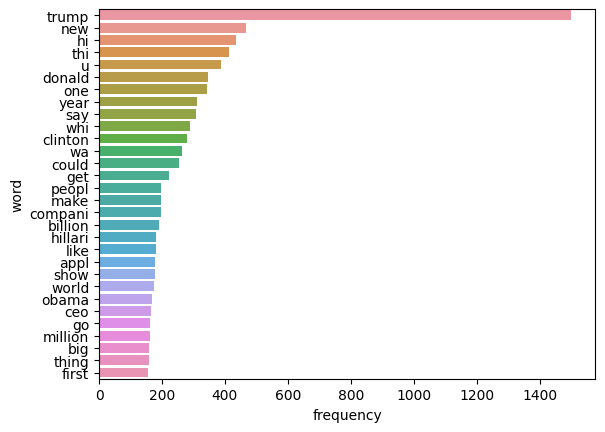

In [36]:
s_words = stopwords.words('english')
additional_stopwords = ['u','ha']
s_words.extend(additional_stopwords)
def word_frequency(sentence,stopwords):
    # joins all the sentenses
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in s_words]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens = [lemmatizer.lemmatize(t) for t in new_tokens]
    counted = Counter(new_tokens)
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    
    return word_freq
freq_doc = word_frequency(entire_text,s_words)
freq_doc = freq_doc[freq_doc.frequency >=150]
ax1 = plt.figure()
sns.barplot(x='frequency',y='word',data=freq_doc.head(100))

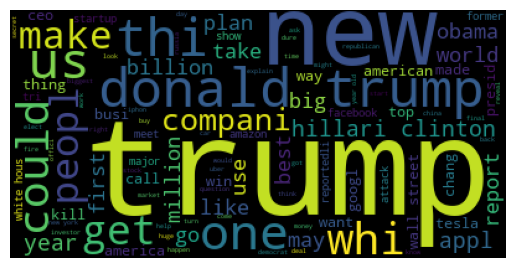

In [38]:
wc = WordCloud(max_words=100,stopwords={'say','ha','wa','u','hi'}).generate_from_text(entire_text)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [39]:
x_data = dtm[dtm.index.isin(vix_data.index)]
y_data = vix_data[vix_data.index.isin(dtm.index)]

In [41]:
split_index = '2016-12-31'
x_train = x_data.loc[:split_index,:]
x_test = x_data.loc[split_index:,:]
y_train = y_data.loc[:split_index]
y_test = y_data.loc[split_index:]

In [42]:
print(np.shape(x_data))

(347, 6929)


In [43]:
# Define alphas for iterative fitting of regularized model
alphas = np.logspace(-2, 0.5, 10)
# Grid search over MSE for the best lambda
dev_lambda = np.empty((2,len(alphas)))
dev_lambda2 = np.empty((2,len(alphas)))
x_data_for_cv = x_train
x_data_for_cv.index = range(len(x_train))
y_data_for_cv = y_train
y_data_for_cv.index = range(len(x_train))
for ind1,(start,end) in enumerate(zip(np.arange(198,219,20),np.arange(218,239,20))):
    X = x_data_for_cv.drop(range(start,end))
    y = y_data_for_cv.drop(range(start,end))
    out_of_sample_X = x_data_for_cv.loc[range(start,end)]
    out_of_sample_y = y_data_for_cv.loc[range(start,end)]
    # We can either manually compute the out of sample prediction of the model
    # or we can use the inbuilt method 'predict'
    for ind2, alph in enumerate(alphas):
        glm_binom = sm.GLM( y ,sm.add_constant( X ),family=sm.families.Binomial())
        glm_binom = glm_binom.fit_regularized(method = "elastic_net",
        L1_wt = 0.5,alpha = alph)
        dev_lambda[ind1,ind2] = 2*metrics.log_loss(out_of_sample_y, glm_binom.predict
        (sm.add_constant(out_of_sample_X)),
        normalize=True)

In [46]:
best_alpha_elnet = alphas[np.min(np.mean(dev_lambda,axis=0))==\
np.mean(dev_lambda,axis=0)][0]
glm_binom = sm.GLM( y_train ,sm.add_constant( x_train ),family=sm.families.Binomial())
glm_binom = glm_binom.fit_regularized(method = "elastic_net",
L1_wt = 0.5,
alpha = best_alpha_elnet)
print(glm_binom.params[glm_binom.params>0])
print(glm_binom.params[glm_binom.params<0])

Series([], dtype: float64)
Series([], dtype: float64)


In [47]:
test_alpha=0.035
glm_binom = sm.GLM( y_train ,sm.add_constant( x_train ),family=sm.families.Binomial())
glm_binom = glm_binom.fit_regularized(method = "elastic_net",
L1_wt = 0.5,
alpha = test_alpha)
print(glm_binom.params[glm_binom.params>0])
print(glm_binom.params[glm_binom.params<0])

new         0.051182
need        0.165414
old         0.104525
chang       0.027809
us          0.113005
war         0.045940
ceo         0.051630
week        0.110955
talk        0.056567
wrong       0.218070
start       0.028988
campaign    0.051952
ted         0.132214
back        0.067584
law         0.044984
cook        0.101217
hit         0.054191
use         0.043262
iphon       0.141772
could       0.033009
point       0.029068
presid      0.153551
lose        0.049874
dtype: float64
world        -0.167805
ha           -0.040072
earn         -0.170473
attack       -0.013553
type         -0.016168
million      -0.117352
made         -0.008611
go           -0.087230
kill         -0.007912
donald       -0.214627
bill         -0.076497
greatest     -0.110907
microsoft    -0.122382
wall         -0.030307
die          -0.013580
republican   -0.114853
dtype: float64


In [58]:
sent_words = ["trump","invest","grow","high","strong","lead","good","risk","debt","oil","loss","war","rate","hous","weak"]
dtm_sentiment = x_data[sent_words]
x_test = dtm_sentiment.loc[split_index:,:]
y_test = y_data.loc[split_index:]
x_data_for_cv = x_data_for_cv[sent_words]
# Define alphas for iterative fitting of regularized model
alphas = np.logspace(-4, 1, 200)
dev_lambda = np.empty((2,len(alphas)))
dev_lambda2 = np.empty((2,len(alphas)))
for ind1,(start,end) in enumerate(zip(np.arange(198,219,20),np.arange(218,239,20))):
    X = x_data_for_cv.drop(range(start,end))
    y = y_data_for_cv.drop(range(start,end))
    out_of_sample_X = x_data_for_cv.loc[range(start,end)]
    out_of_sample_y = y_data_for_cv.loc[range(start,end)]
    for ind2, alph in enumerate(alphas):
        glm_binom = sm.GLM( y ,sm.add_constant( X ),family=sm.families.Binomial())
        glm_binom = glm_binom.fit_regularized(method = "elastic_net",L1_wt = 0.5,alpha = alph)
        dev_lambda[ind1,ind2] = -2*np.sum(np.dot(out_of_sample_y.values.ravel(),
        np.log(glm_binom.predict(sm.add_constant(out_of_sample_X))))+np.dot((1-out_of_sample_y.values.ravel()),
        np.log(1-glm_binom.predict(sm.add_constant(out_of_sample_X)))))
        
best_alpha_elnet = alphas[np.min(np.mean(dev_lambda,axis=0))==\
np.mean(dev_lambda,axis=0)][0]
glm_binom_elnet = sm.GLM( y_data_for_cv ,sm.add_constant( x_data_for_cv ),family=sm.families.Binomial())
glm_binom_elnet = glm_binom_elnet.fit_regularized(method = "elastic_net",L1_wt = 0.5,alpha = best_alpha_elnet)
print(glm_binom_elnet.params)

const     0.0
trump     0.0
invest    0.0
grow      0.0
high      0.0
strong    0.0
lead      0.0
good      0.0
risk      0.0
debt      0.0
oil       0.0
loss      0.0
war       0.0
rate      0.0
hous      0.0
weak      0.0
dtype: float64


Text(0.5, 0, 'Feature')

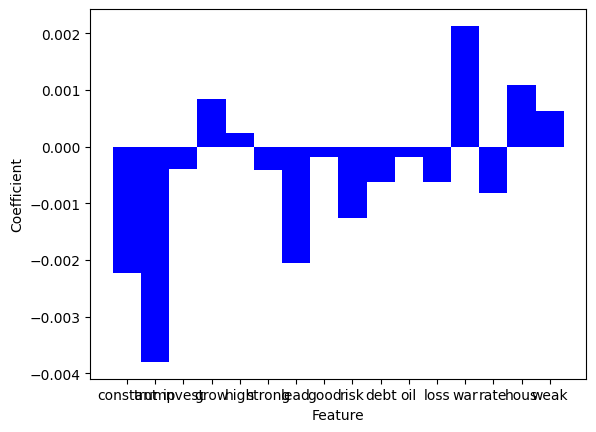

In [59]:
# Grid search over log-loss for the best lambda
dev_lambda = np.empty((2,len(alphas)))
for ind1,(start,end) in enumerate(zip(np.arange(198,219,20),np.arange(218,239,20))):
    X = x_data_for_cv.drop(range(start,end))
    y = y_data_for_cv.drop(range(start,end))
    out_of_sample_X = x_data_for_cv.loc[range(start,end)]
    out_of_sample_y = y_data_for_cv.loc[range(start,end)]
    for ind2, alph in enumerate(alphas):
        glm_binom = sm.GLM( y ,sm.add_constant( X ),family=sm.families.Binomial())
        glm_binom = glm_binom.fit_regularized(L1_wt = 0,alpha = alph)
        dev_lambda[ind1,ind2] = -2*np.sum(np.dot(out_of_sample_y.values.ravel(),
            np.log(glm_binom.predict(sm.add_constant(out_of_sample_X))))
            +np.dot((1-out_of_sample_y.values.ravel()),
            np.log(1-glm_binom.predict(sm.add_constant(out_of_sample_X)))))
best_alpha_ridge = alphas[np.min(np.mean(dev_lambda,axis=0))==\
np.mean(dev_lambda,axis=0)][0]
glm_binom_ridge = sm.GLM( y_data_for_cv ,sm.add_constant( x_data_for_cv ),
family=sm.families.Binomial())
glm_binom_ridge = glm_binom_ridge.fit_regularized(L1_wt = 0,alpha = best_alpha_ridge)
fig = plt.figure()
ax = plt.subplot(111)
l = ['constant']
l.extend(list(x_data_for_cv.columns))
ax.bar(l, glm_binom_ridge.params, width=1, color='b')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature')  

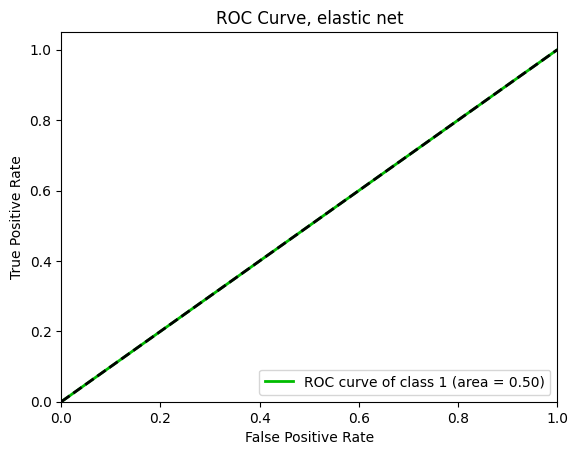

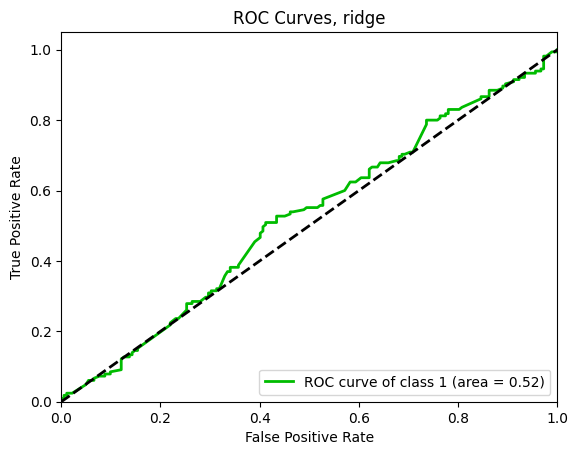

In [60]:
elnet_z = np.ones(347)-glm_binom_elnet.predict(sm.add_constant( dtm_sentiment ))
elnet = pd.concat([elnet_z,glm_binom_elnet.predict(sm.add_constant( dtm_sentiment ))], axis=1)

ax = skplt.metrics.plot_roc(y_data,elnet,
title='ROC Curve, elastic net',
plot_micro=False, plot_macro=False,classes_to_plot=1,
ax=None, figsize=None, cmap='nipy_spectral',
title_fontsize="large", text_fontsize="medium")

ridge_z = np.ones(347)-glm_binom_ridge.predict(sm.add_constant( dtm_sentiment ))
ridge = pd.concat([ridge_z,glm_binom_ridge.predict(sm.add_constant( dtm_sentiment ))], axis=1)

ax = skplt.metrics.plot_roc(y_data,ridge,
title='ROC Curves, ridge',
plot_micro=False, plot_macro=False,classes_to_plot=1,
ax=None, figsize=None, cmap='nipy_spectral',
title_fontsize="large", text_fontsize="medium")


In [61]:
# Elastic net
glm_binom_elnet = sm.GLM(y_train, sm.add_constant(x_data_for_cv), family=sm.families.Binomial())

glm_binom_elnet = glm_binom_elnet.fit_regularized(method = "elastic_net",
L1_wt = 0.5,
alpha = best_alpha_elnet)
elnet_test=pd.concat([pd.DataFrame((glm_binom_elnet.predict(sm.add_constant( x_test ))>=0.5)*1,
columns=['test']),y_test],axis=1)
print('Elastic net: ' + str((elnet_test['test'] == elnet_test['label'])
.sum()/len(elnet_test)))
# Ridge
glm_binom_ridge = sm.GLM( y_train ,sm.add_constant( x_data_for_cv ),
family=sm.families.Binomial())
glm_binom_ridge = glm_binom_ridge.fit_regularized(L1_wt = 0,alpha = best_alpha_ridge)
ridge_test =pd.concat([pd.DataFrame((glm_binom_ridge.predict(sm.add_constant( x_test ))>=0.5)*1,
columns=['test']),y_test],axis=1)
print('Ridge: ' + str((ridge_test['test'] == ridge_test['label'])
.sum()/len(ridge_test)))

Elastic net: 0.47706422018348627
Ridge: 0.5229357798165137
